# Binary Classification with DNS and Combined Dataset

We will now use NTLK (the natural language toolkit) to process just the DNS Records.  This time though, we will import these from both the dataset from the paper for the 24hr-period as well as our own.

In [108]:
from pathlib import Path
import os
import re
import apsw
import pandas as pd
import time


In [109]:
cwd = Path.cwd().parent.parent
print(cwd)

/home/ricdeez/uni/temp/ionetlearn


In [110]:
db1_path = os.path.join(cwd, 'db', 'db01', 'NetCollector.sqlite')
db2_path = os.path.join(cwd, 'db', 'db02', 'NetCollector.sqlite')
db3_path = os.path.join(cwd, 'db', 'db03', 'NetCollector.sqlite')
print(db1_path)

/home/ricdeez/uni/temp/ionetlearn/db/db01/NetCollector.sqlite


In [111]:
from sqlalchemy import create_engine
engine = create_engine(f'sqlite:////{db3_path}')

print(engine)

sql = """

select d.srcPort as srcport, 
       d.dstPort as dstport, 
       sum(d.frameSize) as totalframesize, 
       min(d.frameSize) as minframesize,
       max(d.frameSize) as maxframesize,
       count(*) as pktcount,
       avg(d.frameTTL) as framettl,
       dns.dnsquery,
       d.manufacturer,
       d.device_type
from deviceLog d inner join dnsqueries dns on d.frameNum = dns.pktnum
where d.manufacturer is not null and d.device_type is not null
group by d.srcAddr, d.dstAddr, d.srcPort, d.dstPort

"""

df = pd.read_sql_query(sql, engine)

Engine(sqlite://///home/ricdeez/uni/temp/ionetlearn/db/db03/NetCollector.sqlite)


In [112]:
'''
import sqlite3
conn1 = sqlite3.connect(db1_path)
cur1 = conn1.cursor()

conn2 = sqlite3.connect(db2_path)
cur2 = conn2.cursor()

conn3 = sqlite3.connect(db3_path)
cur3 = conn3.cursor()

sql = """

select d.srcPort, 
       d.dstPort, 
       sum(d.frameSize) as totalframesize, 
       min(d.frameSize) as minframesize,
       max(d.frameSize) as maxframesize,
       count(*) as pktcount,
       avg(d.frameTTL) as framettl,
       dns.dnsquery,
       d.manufacturer,
       d.device_type
from deviceLog d inner join dnsqueries dns on d.frameNum = dns.pktnum
where d.manufacturer is not null and d.device_type is not null
group by d.srcAddr, d.dstAddr, d.srcPort, d.dstPort
"""

arr = []
my_cursors = [cur1, cur2, cur3]
my_cursors = [cur1]

for c in my_cursors:
    for row in c.execute(sql):
        arr.append(row)
    
cols = ['srcport',
        'dstport',
        'totalframesize',
        'minframesize',
        'maxframesize',
        'pktcount',
        'framettl',
        'dnsquery',
        'manufacturer',
        'device_type']
import pandas as pd
df = pd.DataFrame(data=arr, columns=cols)

'''

'\nimport sqlite3\nconn1 = sqlite3.connect(db1_path)\ncur1 = conn1.cursor()\n\nconn2 = sqlite3.connect(db2_path)\ncur2 = conn2.cursor()\n\nconn3 = sqlite3.connect(db3_path)\ncur3 = conn3.cursor()\n\nsql = """\n\nselect d.srcPort, \n       d.dstPort, \n       sum(d.frameSize) as totalframesize, \n       min(d.frameSize) as minframesize,\n       max(d.frameSize) as maxframesize,\n       count(*) as pktcount,\n       avg(d.frameTTL) as framettl,\n       dns.dnsquery,\n       d.manufacturer,\n       d.device_type\nfrom deviceLog d inner join dnsqueries dns on d.frameNum = dns.pktnum\nwhere d.manufacturer is not null and d.device_type is not null\ngroup by d.srcAddr, d.dstAddr, d.srcPort, d.dstPort\n"""\n\narr = []\nmy_cursors = [cur1, cur2, cur3]\nmy_cursors = [cur1]\n\nfor c in my_cursors:\n    for row in c.execute(sql):\n        arr.append(row)\n    \ncols = [\'srcport\',\n        \'dstport\',\n        \'totalframesize\',\n        \'minframesize\',\n        \'maxframesize\',\n        \'p

In [113]:
df.describe()

,totalframesize,minframesize,maxframesize,pktcount,framettl
count,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000
mean,126.273708,81.449574,81.523081,1.459609,84.513336
std,1228.860161,11.022395,11.129762,9.391232,55.934130
min,68.000000,68.000000,68.000000,1.000000,1.000000
25%,73.000000,73.000000,73.000000,1.000000,64.000000
50%,80.000000,75.000000,75.000000,1.000000,64.000000
75%,100.000000,90.000000,90.000000,1.000000,64.000000
max,73500.000000,133.000000,168.000000,513.000000,255.000000


In [114]:
from keras.preprocessing.text import Tokenizer


In [115]:
dns = df['dnsquery']

In [116]:
tk = Tokenizer()
tk.fit_on_texts(dns)
# https://github.com/keras-team/keras/issues/8092
num_words = 50
tk.word_index = {e:i for e,i in tk.word_index.items() if i < num_words} 

In [117]:
encoded_dns=tk.texts_to_matrix(dns, mode='binary')

In [118]:
cols = [f'word_idx{i+1}' for i in range(num_words)]

In [119]:
df2 = pd.DataFrame(data=encoded_dns, columns=cols)

In [120]:
df = pd.concat([df, df2], axis='columns')

In [121]:
df

,srcport,dstport,totalframesize,minframesize,maxframesize,pktcount,framettl,dnsquery,manufacturer,device_type,...,word_idx41,word_idx42,word_idx43,word_idx44,word_idx45,word_idx46,word_idx47,word_idx48,word_idx49,word_idx50
0,25587,53,15210,78,78,195,255.0,netcom.netatmo.net.,Netatmo,Netatmo weather station,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31332,53,72,72,72,1,255.0,pool.ntp.org.,Lifi Labs Management Pty Ltd,Light Bulbs LiFX Smart Bulb,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31333,53,72,72,72,1,255.0,pool.ntp.org.,Lifi Labs Management Pty Ltd,Light Bulbs LiFX Smart Bulb,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31334,53,72,72,72,1,255.0,pool.ntp.org.,Lifi Labs Management Pty Ltd,Light Bulbs LiFX Smart Bulb,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31335,53,72,72,72,1,255.0,pool.ntp.org.,Lifi Labs Management Pty Ltd,Light Bulbs LiFX Smart Bulb,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3981,65468,53,90,90,90,1,64.0,Dan-PC.lan.,AzureWave Technology Inc.,Laptop,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3982,65474,53,101,101,101,1,64.0,client-cf.dropbox.com.,AzureWave Technology Inc.,Laptop,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3983,65506,53,95,95,95,1,64.0,ssl.gstatic.com.,AzureWave Technology Inc.,Laptop,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3984,65509,53,90,90,90,1,64.0,Dan-PC.lan.,AzureWave Technology Inc.,Laptop,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
import numpy as np

df['is_iot'] = np.where(df['device_type'] == 'Other', 0, 1)
ports = ['53', '5353', '443', '5000', '49152', '80', '8080', '123', '49153']
features = ['dstport', 'srcport']
for feature in features:
    for port in ports:
        exec('df[\'{}_is_{}\'] = np.where(df[\'{}\'] == \'{}\', 1, 0)'.format(
                feature, port, feature, port))


In [123]:
drop_columns = ['srcport', 'dstport', 'device_type']

In [124]:
df.drop(drop_columns, axis='columns', inplace=True)

In [125]:
df.drop('dnsquery', axis='columns', inplace=True)

In [126]:
mapping = {k: v for v, k in enumerate((x for x in df['manufacturer'].unique() if len(x)>0),1)}
print(mapping)

{'Netatmo': 1, 'Lifi Labs Management Pty Ltd': 2, 'Invoxia': 3, 'Withings': 4, 'Unknown': 5, 'Belkin International Inc.': 6, 'Physical Graph Corporation': 7, 'AzureWave Technology Inc.': 8, 'Samsung Electronics Co.,Ltd': 9, 'Amazon Technologies Inc.': 10, 'HTC Corporation': 11}


**Categorical data mapping**

For the deep learning algorithm to work, we need to get rid of all categorical data.  For the Manufacturer's we will create a 1:1 mapping of the manufacturer name as per the wireshark OUI lookup dataset and the relative
position of that in our ordered array of unique entries

In [127]:
df['manufacturer'] = df['manufacturer'].map(mapping)

In [128]:
df.describe()

,totalframesize,minframesize,maxframesize,pktcount,framettl,manufacturer,word_idx1,word_idx2,word_idx3,word_idx4,...,dstport_is_49153,srcport_is_53,srcport_is_5353,srcport_is_443,srcport_is_5000,srcport_is_49152,srcport_is_80,srcport_is_8080,srcport_is_123,srcport_is_49153
count,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,3986.0,3986.000000,3986.000000,3986.000000,...,3986.0,3986.0,3986.000000,3986.0,3986.0,3986.0,3986.0,3986.0,3986.0,3986.000000
mean,126.273708,81.449574,81.523081,1.459609,84.513336,6.993728,0.0,0.430256,0.215003,0.215003,...,0.0,0.0,0.000753,0.0,0.0,0.0,0.0,0.0,0.0,0.000753
std,1228.860161,11.022395,11.129762,9.391232,55.934130,2.734181,0.0,0.495174,0.410876,0.410876,...,0.0,0.0,0.027427,0.0,0.0,0.0,0.0,0.0,0.0,0.027427
min,68.000000,68.000000,68.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,73.000000,73.000000,73.000000,1.000000,64.000000,5.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,80.000000,75.000000,75.000000,1.000000,64.000000,8.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,100.000000,90.000000,90.000000,1.000000,64.000000,9.000000,0.0,1.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,73500.000000,133.000000,168.000000,513.000000,255.000000,11.000000,0.0,1.000000,1.000000,1.000000,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [129]:
features = ['totalframesize', 'minframesize', 'maxframesize', 'pktcount', 'framettl']
for feature in features:
    df[feature] = (df[feature] - df[feature].mean()) / \
        (df[feature].max() - df[feature].min())

In [130]:
df.head()

,totalframesize,minframesize,maxframesize,pktcount,framettl,manufacturer,word_idx1,word_idx2,word_idx3,word_idx4,...,dstport_is_49153,srcport_is_53,srcport_is_5353,srcport_is_443,srcport_is_5000,srcport_is_49152,srcport_is_80,srcport_is_8080,srcport_is_123,srcport_is_49153
0,0.205411,-0.053070,-0.035231,0.378009,0.671207,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.000739,-0.145378,-0.095231,-0.000898,0.671207,2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,-0.000739,-0.145378,-0.095231,-0.000898,0.671207,2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,-0.000739,-0.145378,-0.095231,-0.000898,0.671207,2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.000739,-0.145378,-0.095231,-0.000898,0.671207,2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Machine learning - session 1

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures

The first model will be pretty basic and will only be able to `predict` if session data corresponds to an IoT device or not.

Later runs will refine the model to try to predict the device name from the data that we pass to it.  The DNN will be compriosed of the following layers:

[Input Layer: 4 inputs] -> [Hidden layer 1: 32 nodes] -> [Hidden layer 2: 64 nodes] -> [Hidden layer 3: 32 nodes] -> [Output layer: 1 output]

the `relu` activation function defined as f(x) = max(0, x) will be used for each layer apart from the last layer which will use the sigmoid function.  The adam optimiser will be used and the loss function will be the binary_crossentropy which is best for binary classification problems.


In [131]:
from sklearn.model_selection import train_test_split

In [132]:
features = df.drop('is_iot', axis=1).values

In [133]:
labels = df['is_iot'].values

In [134]:
df.shape[1]

75

In [135]:
features.shape[1]

74

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [137]:
print(len(labels), len(Y_train), len(Y_test), sep='::')

3986::3188::798


In [138]:
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_tree
from matplotlib import pyplot
from numpy import sort

In [139]:
model = XGBClassifier()


In [140]:
# model.fit(X_train, Y_train)
#  predictions = model.predict(X_test)



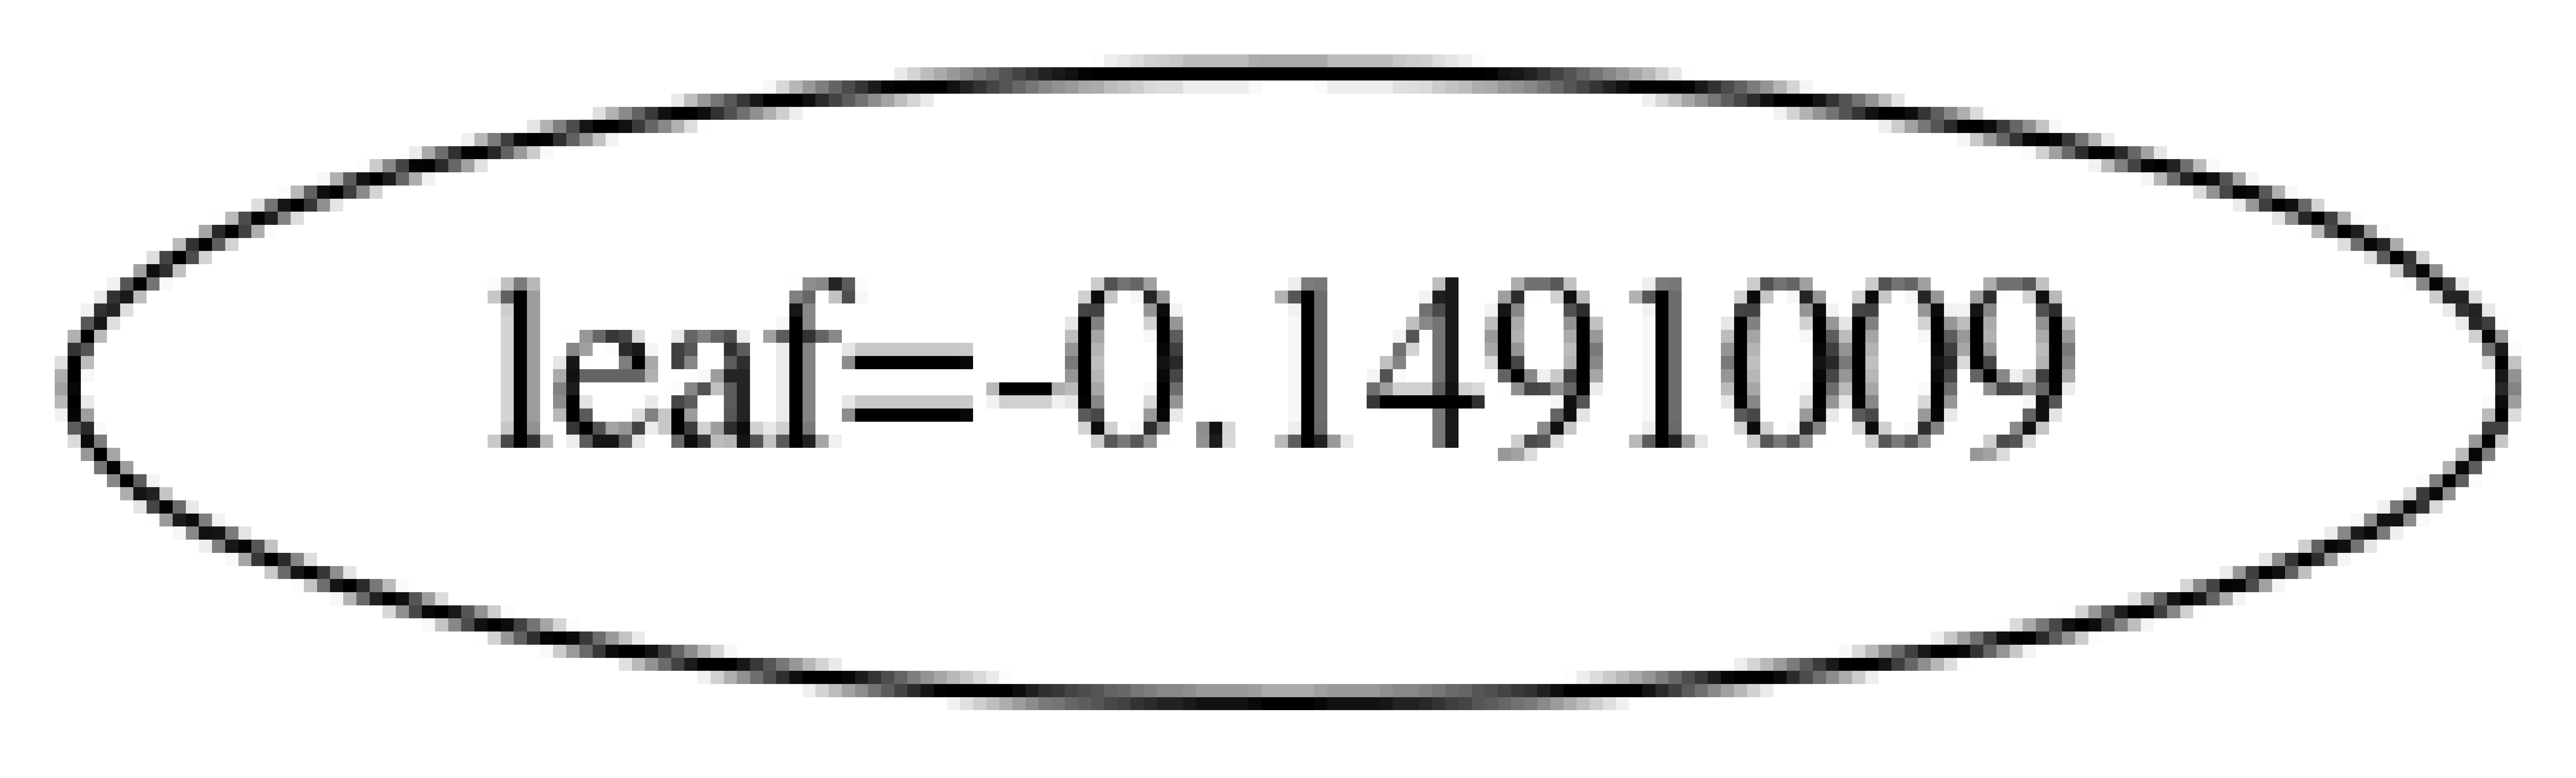

In [141]:
model.fit(X_train, Y_train)
plot_tree(model, num_trees=4, rankdir='LR')
fig = pyplot.gcf()
fig.set_size_inches(150, 200)

pyplot.show()



In [142]:
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print("Accuracy: %.8f%% (%.8f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 100.00000000% (0.00000000%)


In [101]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(Y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:5

Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


Thresh=nan, n=74, Accuracy: 100.00%
Thresh=nan, n=74, Accuracy: 100.00%


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:161: RuntimeWarning: invalid value encountered in less
  mask[scores < threshold] = False


In [136]:
thresholds

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00021713, 0.001196  , 0.00189129, 0.00293313, 0.00582664,
       0.00657101, 0.007887  , 0.0099196 , 0.01011719, 0.01077437,
       0.01616816, 0.01681905, 0.01733759, 0.02165858, 0.02343172,
       0.02492435, 0.03168509, 0.0366894 , 0.04097137, 0.0433169 ,
       0.04845143, 0.05557815, 0.06071996, 0.0710758 , 0.08837488,
       0.09807105, 0.11651653, 0.1308766 ], dtype=float32)